In [1]:
from pdeep.mhc.mhc_binding_model import *
from pdeep.mhc.plotting_utils import *
from pdeep.mhc.mhc_utils import *
from pdeep.mhc.mhc_binding_retriever import MHCBindingRetriever
import matplotlib.pyplot as plt

hla_model_pt = "HLA_model_v0613.pt"
pept_model_pt = "pept_model_v0613.pt"

pept_encoder = ModelSeqEncoder().to("cuda")
hla_encoder = ModelHlaEncoder().to("cuda")
hla_encoder.load_state_dict(torch.load(f"model/{hla_model_pt}", map_location="cuda"))
pept_encoder.load_state_dict(torch.load(f"model/{pept_model_pt}", map_location="cuda"))

fasta_list = ["uniprotkb_UP000005640_AND_reviewed_true_2024_03_01.fasta"]

2024-08-05 15:07:16> Failed to extract font properties from /usr/share/fonts/truetype/noto/NotoColorEmoji.ttf: In FT2Font: Can not load face (unknown file format; error code 0x2)


In [2]:
with open(f"embeds/{hla_model_pt}.embed", "rb") as f:
    data_dict = pickle.load(f)
    hla_df = data_dict["protein_df"]
    hla_embeds = data_dict["embeds"]
    umap_reducer = data_dict["umap_reducer"]

retriever = MHCBindingRetriever(
    hla_encoder, pept_encoder, hla_df, hla_embeds,
    fasta_list, digested_pept_lens=(9,9)
)

In [3]:
def plot_dist(allele, pept_groups, metric="distance", save=""):
    pept_df = pept_groups.get_group(allele)
    embed = hla_embeds[retriever.dataset.allele_idxes_dict[allele][0]]
    df = retriever.get_binding_metrics_for_embeds(
        embed, pept_df.sequence.values
    )
    df["allele"] = allele
    np.random.seed(1337)
    rnd_pept_df = retriever.dataset.digest.get_random_pept_df(len(df))
    rnd_df = retriever.get_binding_metrics_for_embeds(
        embed, rnd_pept_df.sequence.values
    )
    rnd_df["allele"] = "random"
    df = pd.concat([df, rnd_df], ignore_index=True).rename(
        columns={
            "best_allele_dist": "distance",
            "best_allele_rank": "rank",
            "best_allele_fdr": "fdr",
        }
    )

    fig = px.histogram(
        df, x=metric, color="allele",
        marginal="rug", barmode="overlay",
        nbins=100, hover_data=["allele", "distance", "rank", "fdr"]
    )
    fig.update_layout(template="plotly_white")
    fig.show()
    if save:
        fig.write_image(save)

    # sns.kdeplot(data=df, x="best_allele_dist", hue="allele")
    return df

def plot_logo(alleles, seqs, plot_allele, fdr=0.02):
    metrics_df = retriever.get_binding_metrics_for_peptides(
        alleles, seqs
    )
    kmers = [9]
    fig, axes = plt.subplots(3, len(kmers),
        sharey='row', sharex='col',
        figsize=(10,5)
    )
    plot_motif_multi_mer(metrics_df, allele_col="best_allele", allele=plot_allele, kmers=kmers, axes=axes[0])
    plot_motif_multi_mer(metrics_df.query("best_allele_fdr<=@fdr").copy(), allele_col="best_allele", allele=plot_allele, kmers=kmers, axes=axes[1])
    plot_motif_multi_mer(metrics_df.query("best_allele_fdr>@fdr").copy(), allele_col="best_allele", allele=plot_allele, kmers=kmers, axes=axes[2])
    plt.show()
    return metrics_df

In [4]:
test_df = pd.read_table("all_alleles/train_data/leave_one_ABC_type/test_df.tsv")
test_df = pd.concat([test_df,
    load_hla_pep_df("all_alleles/netmhcpan")], ignore_index=True
)
pept_groups = test_df.groupby("allele")

In [5]:
compare_allele_list = [
    "A01_02",
    "A23_04",
    "B07_03",
    "B40_03",
    "C04_04",
    "C17_02"
]

In [6]:
rand_pep_list = [retriever.dataset.digest.get_random_pept_df(10000).sequence.values.astype("U") 
                 for _ in range(len(compare_allele_list))]

allele=A01_02, kmer=9, n=222


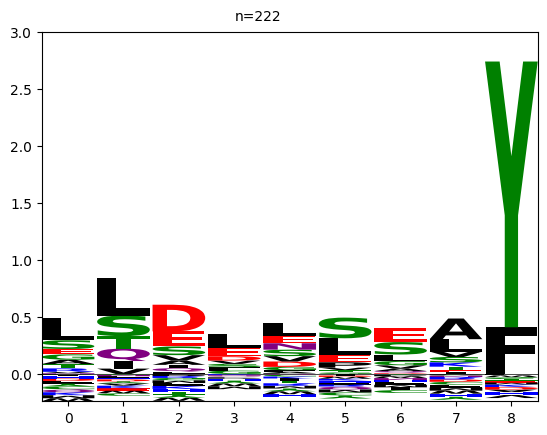

allele=A23_04, kmer=9, n=194


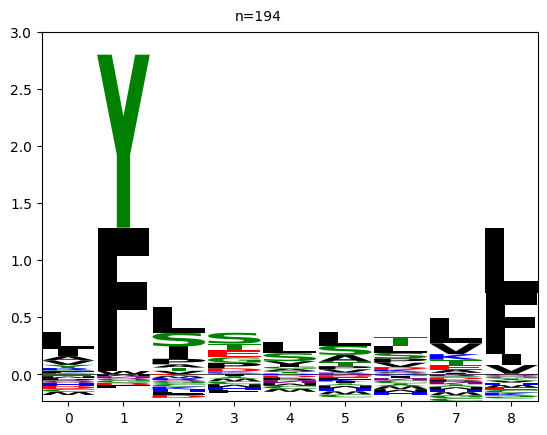

allele=B07_03, kmer=9, n=284


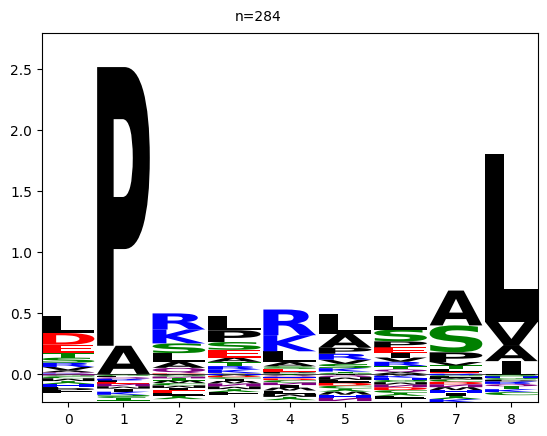

allele=B40_03, kmer=9, n=216


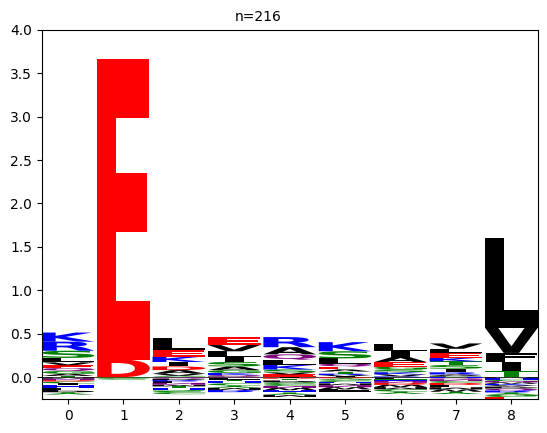

allele=C04_04, kmer=9, n=220


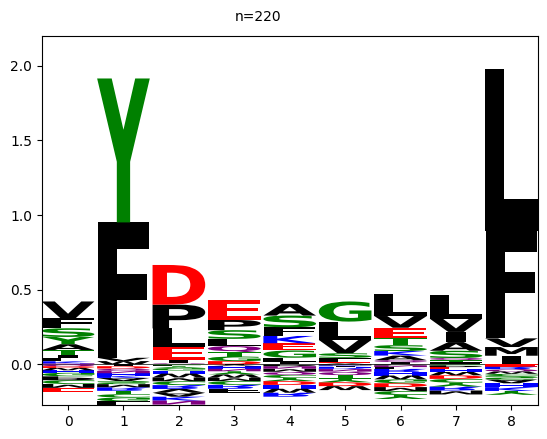

allele=C17_02, kmer=9, n=251


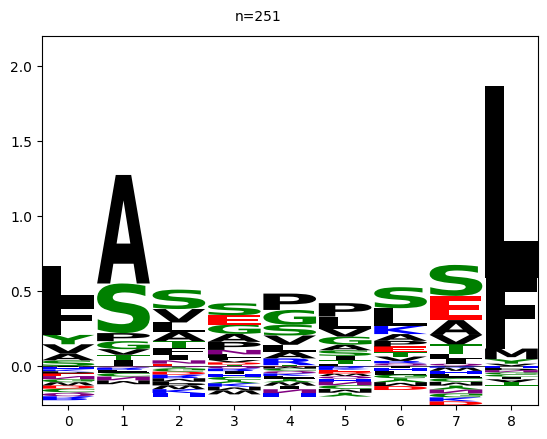

In [7]:
for i in range(len(compare_allele_list)):
    
    tmp_allele = compare_allele_list[i]
    metrics_df = retriever.get_binding_metrics_for_peptides(
        [tmp_allele], rand_pep_list[i]
    )
    kmers = [9]
    plot_motif_multi_mer(metrics_df.query("best_allele_fdr<=0.02").copy(), allele_col="best_allele", allele=tmp_allele, kmers=kmers)
    plt.show()

In [8]:
# for i in range(len(rand_pep_list)):
#     with open(f"data/compare_test/rand_pep_list_for_{compare_allele_list[i]}.txt", "w") as f:
#         for k in range(len(rand_pep_list[i])):
#             f.write(rand_pep_list[i][k])
#             f.write("\n")

In [9]:
# with open("data/compare_test/netmhcpan_run_batch.sh", "w") as f:
#     for i in range(len(compare_allele_list)):
#         modify_allele = compare_allele_list[i].replace("_", ":")
#         f.write(f"/home/chengjt/software/netMHCpan/netMHCpan-4.1/netMHCpan -p rand_pep_list_for_{compare_allele_list[i]}.txt -BA -a HLA-{modify_allele} > compare0604_{compare_allele_list[i]}.out\n")

In [11]:
df_list = []
rank = 2
for tmp_allele in compare_allele_list:
    df = pd.read_csv(f"data/compare_test/compare0604_{tmp_allele}.out", delim_whitespace=True)
    df = df.query(f"`%Rank_EL`<={rank}").copy()
    df["sequence"] = df["Peptide"]
    df = df[["sequence"]]
    df['best_allele'] = tmp_allele
    df_list.append(df)
df_list

[       sequence best_allele
 19    FSILLVFDY      A01_02
 122   ANYHSSNAY      A01_02
 128   LDKDHHALY      A01_02
 210   GLQALDEEY      A01_02
 213   TQEYVLHVY      A01_02
 ...         ...         ...
 9944  STIPSGHVW      A01_02
 9947  TTNKKGEIF      A01_02
 9983  GIMETFKTY      A01_02
 9992  NITGSNSSY      A01_02
 9997  CQDLSSSLH      A01_02
 
 [335 rows x 2 columns],
        sequence best_allele
 27    PYLKDPAAY      A23_04
 29    YYNIHRHSI      A23_04
 48    DYNAPDSKW      A23_04
 56    VFLQLRVAV      A23_04
 83    LYGPFLMLY      A23_04
 ...         ...         ...
 9793  KWVRSYDFI      A23_04
 9802  NWATLAQKL      A23_04
 9942  VQEGSSATF      A23_04
 9987  IMDGHTIYL      A23_04
 9991  GWVPPPPGF      A23_04
 
 [325 rows x 2 columns],
        sequence best_allele
 32    IVSSSNQAL      B07_03
 62    APRPGQHAL      B07_03
 107   AAGRKTVQL      B07_03
 202   LAKSMAISL      B07_03
 254   IPRDAFRSL      B07_03
 ...         ...         ...
 9800  QPQPQPQPS      B07_03
 9913  SLREFSNFL  

allele=A01_02, kmer=9, n=335


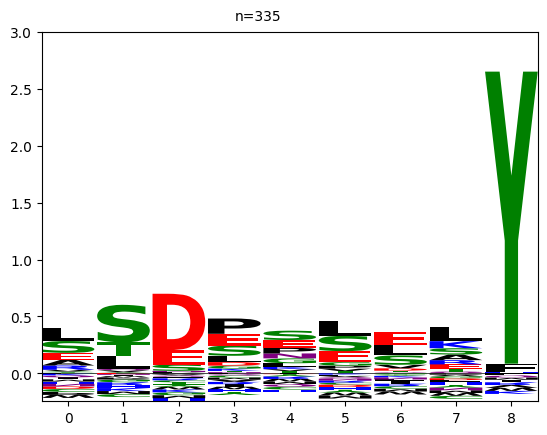

allele=A23_04, kmer=9, n=325


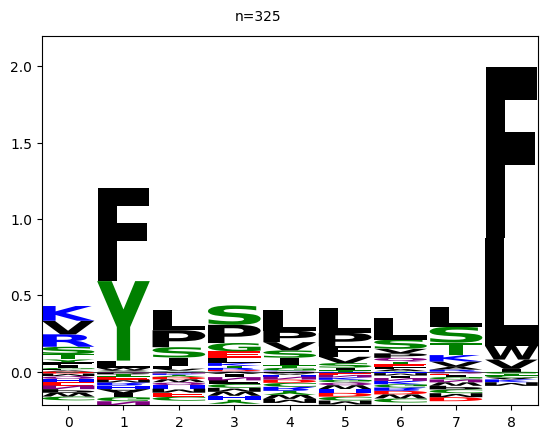

allele=B07_03, kmer=9, n=438


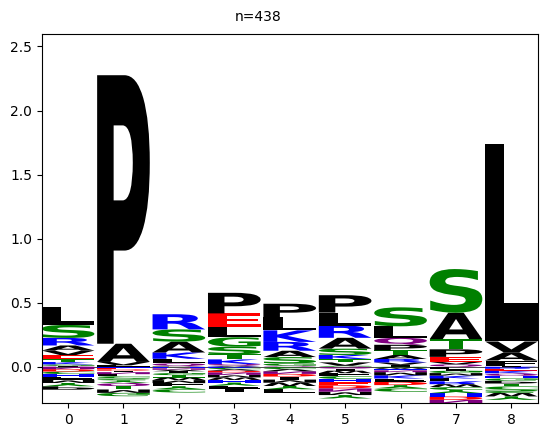

allele=B40_03, kmer=9, n=407


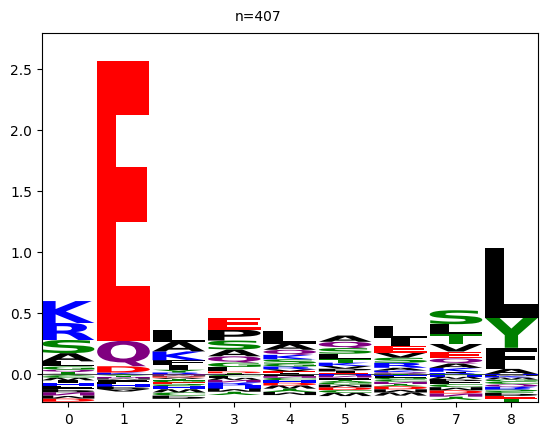

allele=C04_04, kmer=9, n=696


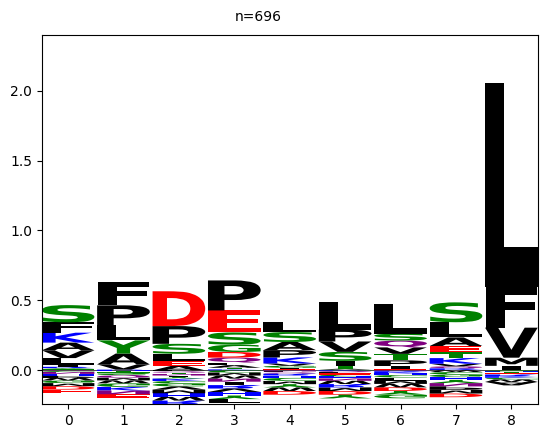

allele=C17_02, kmer=9, n=665


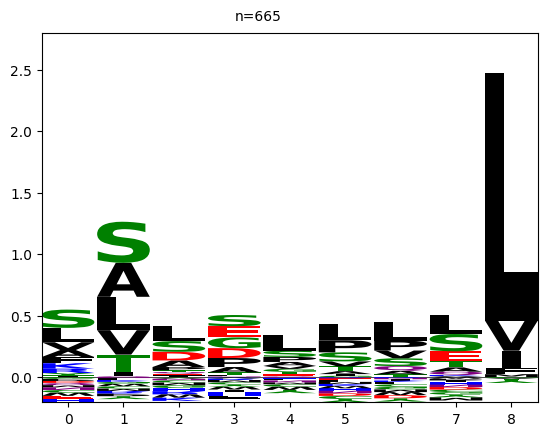

In [12]:
for i in range(len(compare_allele_list)):
    tmp_allele = compare_allele_list[i]

    metrics_df = df_list[i]
    
    kmers = [9]

    plot_motif_multi_mer(metrics_df.copy(), allele_col="best_allele", allele=tmp_allele, kmers=kmers)
    
    plt.show()